Understanding Hired Rides in NYC
Project prompt

This scaffolding notebook may be used to help setup your final project. It's totally optional whether you make use of this or not.

If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish.

Anything in italics (prose) or comments (in code) is meant to provide you with guidance. Remove the italic lines and provided comments before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading.

All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.

Project Setup

In [75]:
#TODO:// 1. bonus: Test needed; [NOT DONE]
# 2. table type and primary key should be checked; [DONE]
# 3. docuement need to be enhanced. [DONE]
# 4. the way download the data?  [DDNE]
# 5.check the correctness of value;  [DONE]
# 6.bonus: sunset table and one more vis? [NOT DONE]

from typing import List, Dict, Any, Tuple
from tqdm import tqdm 
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from ipywidgets import interact
from scipy.stats import sem, t
from ipywidgets import SelectMultiple
from folium.plugins import HeatMap
import bs4
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import requests
import sqlalchemy as db
import ipywidgets as widgets
import seaborn as sns
import geopandas as gpd
import re 
import os
import folium
import warnings
import unittest
warnings.filterwarnings("ignore")

In [3]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = ""
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "./weather_data"

PARQUET_DIR = "parquet_files"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

engine = create_engine(DATABASE_URL)

In [4]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

Part 1: Data Preprocessing

Load Taxi Zones

In [5]:
def load_taxi_zones(shapefile:str='./taxi_zones.shp') -> gpd.GeoDataFrame :
    """
    Load the taxi zone shapefile into a GeoDataFrame

    Keyword Arguments:
    shapefile {str} -- the path to the shapefile (default: {'./taxi_zones.shp'})

    Returns:
    gpd.GeoDataFrame -- the GeoDataFrame containing the taxi zones
    """
    gdf = gpd.read_file(shapefile).to_crs(4326)
    gdf['latitude'] = gdf.geometry.centroid.y
    gdf['longitude'] = gdf.geometry.centroid.x
    gdf = gdf[['LocationID', 'latitude', 'longitude']]
    return gdf 

In [6]:
gdf = load_taxi_zones()

Calculate Sample Size

In [7]:
def calculate_sample_size(population,z=1.96, e=0.05) -> int:
    """
    calculate the sample size needed for a given population
    :param population: the size of the population
    :param z: the parameter of confidence level
    :param e: the margin of error

    :return: the sample size needed
    """
    n0 = z**2 * 0.5 * 0.5 / e**2
    n = n0 / (1 + (n0 - 1) / population)
    return int(n)

Common Functions

In [8]:
def convert_location_id_to_lat_lon(df:pd.DataFrame) -> pd.DataFrame:
    """
    convert the pickup and dropoff location id to latitude and longitude

    Keyword arguments:
    df -- the dataframe to be converted

    Returns:
    pd.DataFrame -- the dataframe with latitude and longitude columns
    """
    df = df.merge(gdf, left_on='PULocationID', right_on='LocationID', how='left').rename(columns={'latitude':'PULatitude', 'longitude':'PULongitude'}).drop(columns='LocationID')
    df = df.dropna(subset=['PULatitude', 'PULongitude'])
    df = df.merge(gdf, left_on='DOLocationID', right_on='LocationID', how='left').rename(columns={'latitude':'DOLatitude', 'longitude':'DOLongitude'}).drop(columns='LocationID')
    df = df.dropna(subset=['DOLatitude', 'DOLongitude'])
    return df

In [9]:
def filter_urls(all_urls:List[str],re_pattern :str= '(fhvhv)_tripdata_.*?(202[0-4])-([0-1][0-9])') -> List[str]:
    """
    filter url with given pattern

    Keyword arguments:
    all_urls -- the list of urls to be filtered
    re_pattern -- the pattern to be matched

    Returns:
    List[str] -- the list of filtered urls
    """
    pattern = re.compile(f"{re_pattern}")
    result = []
    for url in all_urls:
        filename = url.split("/")[-1]
        match = pattern.match(filename)
        if match is not None:
            result.append(url)
    return result



class TestFilterUrls(unittest.TestCase):
    def test_filter_urls_valid(self):
        """Test filtering URLs with valid patterns"""
        all_urls = [
            "https://example.com/fhvhv_tripdata_2023-01.parquet",
            "https://example.com/fhvhv_tripdata_2024-12.parquet",
            "https://example.com/other_tripdata_2023-01.parquet",
            "https://example.com/fhvhv_tripdata_2025-01.parquet"
        ]
        expected = [
            "https://example.com/fhvhv_tripdata_2023-01.parquet",
            "https://example.com/fhvhv_tripdata_2024-12.parquet"
        ]
        self.assertEqual(filter_urls(all_urls), expected)

    def test_filter_urls_invalid(self):
        """Test filtering URLs with no matches"""
        all_urls = [
            "https://example.com/other_tripdata_2023-01.parquet",
            "https://example.com/dsadadasdad.parquet",
            "https://example.com/fhvhv_tripdata_2025-01.parquet"
        ]
        expected = []  
        self.assertEqual(filter_urls(all_urls), expected)

    def test_filter_urls_empty(self):
        """Test filtering URLs when the list is empty"""
        all_urls = []
        expected = []  
        self.assertEqual(filter_urls(all_urls), expected)

    def test_filter_urls_custom_pattern(self):
        """Test filtering URLs with a custom pattern"""
        all_urls = [
            "https://example.com/fhvhv_tripdata_2023-01.csv",
            "https://example.com/taxidata_2023-01.csv"
        ]
        custom_pattern = r"taxidata_.*?(202[0-4])-([0-1][0-9])"
        expected = ["https://example.com/taxidata_2023-01.csv"]
        self.assertEqual(filter_urls(all_urls, re_pattern=custom_pattern), expected)


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestFilterUrls))

....
----------------------------------------------------------------------
Ran 4 tests in 0.003s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

Process Taxi Data

In [10]:
def remove_invalid_record_of_taxi_data(df:pd.DataFrame) -> pd.DataFrame:
    """
    remove the data points outside of NYC
    remove the data with a nan pick
    remove the distance less equal than 0
    
    Keyword arguments:

    Returns:
    pd.Dataframe -- the row if it is valid, None otherwise
    """
    valid = (
            (df['PULatitude'].between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])) &
            (df['PULongitude'].between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])) &
            (df['DOLatitude'].between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])) &
            (df['DOLongitude'].between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])) &
            (~df['tpep_pickup_datetime'].isna()) &
            (~df['tpep_dropoff_datetime'].isna()) &
            (df['trip_distance'] > 0)
        )
    
    return df[valid]

def get_and_clean_month(url:str)->pd.DataFrame:
    """
    download and clean the data from the given url

    Keyword arguements:
    url -- the url to download the data

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """
    try:
        parquet_file = f"{url.split('/')[-1].strip()}"
        if os.path.exists(f"{PARQUET_DIR}/{parquet_file}"):
            df = pd.read_parquet(f"{PARQUET_DIR}/{parquet_file}")
        else:
            # wget = f"wget {url.strip()} -O {PARQUET_DIR}/{parquet_file}"
            # os.system(wget)

            response = requests.get(url.strip(), stream=True)
            response.raise_for_status()  # Raise an exception for HTTP errors
            file_path = os.path.join(PARQUET_DIR, parquet_file)
            # Save the content to the file
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            df = pd.read_parquet(f"{PARQUET_DIR}/{parquet_file}")
            
        n = calculate_sample_size(df.shape[0])
        df = df.sample(n)
        df = convert_location_id_to_lat_lon(df)
        df = remove_invalid_record_of_taxi_data(df)

        return df
    except Exception as e:
        raise


In [11]:
def get_and_clean_taxi_data(parquet_urls:List[str]) -> pd.DataFrame:
    """
    download and clean the data from the given urls

    Keyword arguements:
    parquet_urls -- the list of urls to download the data

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """

    all_taxi_dataframes = []
    parquet_urls = filter_urls(parquet_urls,'(yellow)_tripdata_.*?(202[0-4])-([0-1][0-9])')
    for parquet_url in tqdm(parquet_urls):
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month(parquet_url)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

In [12]:
def get_all_urls_from_taxi_page(url:str) -> List[str]:
    """
    get all urls from the page of the given url

    Keyword arguments:
    url -- the url to get all urls from

    Returns:
    List[str] -- the list of all urls
    """
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    urls = [a['href'] for a in soup.find_all('a', href=True)]
    return urls


def find_all_parquet_urls(urls:List[str]) -> List[str]:
    """
    filter the all parquet urls 

    Keyword arguments:
    urls -- the list of urls to be filtered

    Returns:
    List[str] -- the list of filtered urls
    """
    parquet_urls = [url for url in urls if 'parquet' in url]
    return parquet_urls

class TestFindAllParquetUrls(unittest.TestCase):
    def test_find_all_parquet_urls_valid(self):
        """Test filtering with valid parquet URLs"""
        urls = [
            "https://example.com/data_2023.parquet",
            "https://example.com/data_2024.csv",
            "https://example.com/file.parquet",
            "https://example.com/otherfile.json"
        ]
        expected = [
            "https://example.com/data_2023.parquet",
            "https://example.com/file.parquet"
        ]
        self.assertEqual(find_all_parquet_urls(urls), expected)

    def test_find_all_parquet_urls_no_matches(self):
        """Test filtering when there are no parquet URLs"""
        urls = [
            "https://example.com/data_2023.csv",
            "https://example.com/data_2024.json",
            "https://example.com/file.txt"
        ]
        expected = []
        self.assertEqual(find_all_parquet_urls(urls), expected)

    def test_find_all_parquet_urls_empty(self):
        """Test filtering with an empty list"""
        urls = []
        expected = []
        self.assertEqual(find_all_parquet_urls(urls), expected)


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestFindAllParquetUrls))

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [13]:
def get_taxi_data() ->pd.DataFrame:
    """ 
    get the taxi data from the TLC website
    
    Returns:
    pd.DataFrame -- the taxi data
    """
    if not os.path.exists(PARQUET_DIR):
        os.mkdir(PARQUET_DIR)
    all_urls = get_all_urls_from_taxi_page(TLC_URL)
    all_parquet_urls = find_all_parquet_urls(all_urls)
    taxi_data = get_and_clean_taxi_data(all_parquet_urls)
    return taxi_data

In [14]:
taxi_data_uncleaned = get_taxi_data()

100%|██████████| 57/57 [00:15<00:00,  3.63it/s]


Normalize Columns

In [15]:
taxi_data_cleaned = taxi_data_uncleaned[['tpep_pickup_datetime','tpep_dropoff_datetime',
                               'trip_distance','fare_amount','extra','mta_tax','improvement_surcharge',
                               'tolls_amount',
                               'PULatitude','PULongitude',
                               'DOLatitude','DOLongitude']]

taxi_data_cleaned['base_fare'] = taxi_data_cleaned['fare_amount'] 
taxi_data_cleaned['tax'] = taxi_data_cleaned['mta_tax'] + taxi_data_cleaned['extra']
taxi_data_cleaned['tolls'] = taxi_data_cleaned['tolls_amount']
taxi_data_cleaned['surcharge'] = taxi_data_cleaned['improvement_surcharge']
taxi_data_cleaned = taxi_data_cleaned.rename(columns={'tpep_pickup_datetime':'trip_pickup_datetime',
                                                      'tpep_dropoff_datetime':'trip_dropoff_datetime',
                                                      'trip_distance':'trip_miles',
                                                      'base_fare':'base_fare',
                                                      'tax':'tax',
                                                      'tolls':'tolls',
                                                      'PULatitude':'pickup_latitude',
                                                      'PULongitude':'pickup_longitude',
                                                      'DOLatitude':'dropoff_latitude',
                                                      'DOLongitude':'dropoff_longitude'})
taxi_data_cleaned = taxi_data_cleaned[['trip_pickup_datetime','trip_dropoff_datetime','trip_miles','base_fare','tax','tolls','surcharge',
                                       'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]
taxi_data = taxi_data_cleaned

In [16]:
taxi_data.head()

,trip_pickup_datetime,trip_dropoff_datetime,trip_miles,base_fare,tax,tolls,surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2024-01-03 23:35:13,2024-01-03 23:41:41,1.16,8.6,1.5,0.00,1.0,40.758028,-73.977698,40.773633,-73.981532
1,2024-01-01 20:03:55,2024-01-01 20:36:52,17.31,70.0,0.5,6.94,1.0,40.678953,-73.790986,40.703358,-74.011515
2,2024-01-09 14:54:00,2024-01-09 15:14:25,2.14,18.4,0.5,0.00,1.0,40.758028,-73.977698,40.765484,-73.954739
3,2024-01-12 05:39:01,2024-01-12 06:05:24,21.50,98.6,1.0,21.38,1.0,40.762253,-73.989845,40.691831,-74.174000
4,2024-01-02 10:25:29,2024-01-02 10:31:10,0.80,7.2,3.0,0.00,1.0,40.766948,-73.959635,40.756688,-73.972356


In [17]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21215 entries, 0 to 376
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trip_pickup_datetime   21215 non-null  datetime64[ns]
 1   trip_dropoff_datetime  21215 non-null  datetime64[ns]
 2   trip_miles             21215 non-null  float64       
 3   base_fare              21215 non-null  float64       
 4   tax                    21215 non-null  float64       
 5   tolls                  21215 non-null  float64       
 6   surcharge              21215 non-null  float64       
 7   pickup_latitude        21215 non-null  float64       
 8   pickup_longitude       21215 non-null  float64       
 9   dropoff_latitude       21215 non-null  float64       
 10  dropoff_longitude      21215 non-null  float64       
dtypes: datetime64[ns](2), float64(9)
memory usage: 1.9 MB


In [18]:
taxi_data.describe()

,trip_miles,base_fare,tax,tolls,surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,21215.000000,21215.000000,21215.000000,21215.000000,21215.000000,21215.000000,21215.000000,21215.000000,21215.000000
mean,3.322651,15.306648,1.701640,0.457852,0.549126,40.753322,-73.966494,40.755476,-73.970308
std,4.154507,14.761170,1.539493,1.840801,0.357935,0.032496,0.045564,0.033547,0.036921
min,0.010000,-500.000000,-8.000000,-12.750000,-1.000000,40.576961,-74.029892,40.576961,-74.174000
25%,1.080000,7.200000,0.500000,0.000000,0.300000,40.740439,-73.989845,40.740337,-73.989845
50%,1.810000,10.700000,1.000000,0.000000,0.300000,40.758028,-73.977698,40.758028,-73.977698
75%,3.400000,17.700000,3.000000,0.000000,1.000000,40.773633,-73.961764,40.775932,-73.959635
max,39.940000,150.000000,12.250000,33.760000,1.000000,40.897932,-73.739473,40.899529,-73.726655


### Processing Uber Data

In [19]:
def remove_invalid_records_of_uber_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove invalid data points from the Uber dataset.

    Keyword arguments:
    df -- the DataFrame to clean

    Returns:
    pd.DataFrame -- the cleaned DataFrame
    """
    valid = (
        (df['PULatitude'].between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])) &
        (df['PULongitude'].between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])) &
        (df['DOLatitude'].between(NEW_YORK_BOX_COORDS[0][0], NEW_YORK_BOX_COORDS[1][0])) &
        (df['DOLongitude'].between(NEW_YORK_BOX_COORDS[0][1], NEW_YORK_BOX_COORDS[1][1])) &
        (~df['pickup_datetime'].isna()) &
        (~df['dropoff_datetime'].isna()) &
        (df['trip_miles'] > 0)
    )

    # Return the filtered DataFrame
    return df[valid]


def get_and_clean_uber_month(url:List[str]) -> pd.DataFrame:
    """
    download and clean the data from the given url of uber

    Keyword arguements:
    url -- the url to download the data

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """

    try:
        parquet_file = f"{url.split('/')[-1].strip()}"
        if os.path.exists(f"{PARQUET_DIR}/{parquet_file}"):
            df = pd.read_parquet(f"{PARQUET_DIR}/{parquet_file}")
        else:
            # wget = f"wget {url.strip()} -O {PARQUET_DIR}/{parquet_file}"
            # os.system(wget)

            response = requests.get(url.strip(), stream=True)
            response.raise_for_status()
            file_path = os.path.join(PARQUET_DIR, parquet_file)
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            df = pd.read_parquet(f"{PARQUET_DIR}/{parquet_file}")
            
        n = calculate_sample_size(df.shape[0])
        df = df[df['hvfhs_license_num']=='HV0003']
        df = df.sample(n)
        df = convert_location_id_to_lat_lon(df)
        df = remove_invalid_records_of_uber_data(df)

        return df
    except Exception as e:
        raise


In [20]:
def get_and_clean_uber_data(parquet_urls:List[str]) -> pd.DataFrame:
    """
    download and clean the data from the given urls of uber

    Keyword arguements:
    parquet_urls -- the list of urls to download the data

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """

    all_uber_dataframes = []

    uber_parquet_urls = filter_urls(parquet_urls, re_pattern='(fhvhv)_tripdata_.*?(202[0-4])-([0-1][0-9])')

    for parquet_url in tqdm(uber_parquet_urls):
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_uber_month(parquet_url)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_uber_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    uber_data = pd.concat(all_uber_dataframes)
    return uber_data

In [21]:
def get_uber_data() -> pd.DataFrame :
    """
    get the uber data from the TLC website

    Returns:
    pd.DataFrame -- the uber data
    """

    if not os.path.exists(PARQUET_DIR):
        os.mkdir(PARQUET_DIR)
    all_urls = get_all_urls_from_taxi_page(TLC_URL)
    all_parquet_urls = find_all_parquet_urls(all_urls)
    taxi_data = get_and_clean_uber_data(all_parquet_urls)
    return taxi_data

In [22]:
uber_data_uncleaned = get_uber_data()

100%|██████████| 57/57 [06:52<00:00,  7.24s/it]


### Normalize Columns

In [23]:
uber_data_cleaned = uber_data_uncleaned[['pickup_datetime','dropoff_datetime','trip_miles',
                               'base_passenger_fare','tolls','bcf','sales_tax','congestion_surcharge',
                               'PULatitude','PULongitude',
                               'DOLatitude','DOLongitude']]

uber_data_cleaned['base_fare'] = uber_data_cleaned['base_passenger_fare'] #+ uber_data_cleaned['bcf']
uber_data_cleaned['surcharge'] = uber_data_cleaned['congestion_surcharge']
uber_data_cleaned['tax'] = uber_data_cleaned['sales_tax'] +   uber_data_cleaned['bcf'] # TODO: check if this is correct
uber_data_cleaned['tolls'] = uber_data_cleaned['tolls']
uber_data_cleaned = uber_data_cleaned.rename(columns={
    'trip_miles':'trip_distance',
    'pickup_datetime':'trip_pickup_datetime',
    'dropoff_datetime':'trip_dropoff_datetime',
    'base_fare':'base_fare',
    'tax':'tax',
    'tolls':'tolls',
    'surcharge':'surcharge',
    'PULatitude':'pickup_latitude',
    'PULongitude':'pickup_longitude',
    'DOLatitude':'dropoff_latitude',
    'DOLongitude':'dropoff_longitude'
})

uber_data_cleaned = uber_data_cleaned[['trip_pickup_datetime','trip_dropoff_datetime','trip_distance','base_fare','tax','tolls','surcharge',
                                       'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]

uber_data = uber_data_cleaned

In [24]:
uber_data.head()

,trip_pickup_datetime,trip_dropoff_datetime,trip_distance,base_fare,tax,tolls,surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2024-01-01 18:30:58,2024-01-01 19:13:48,7.22,39.06,5.35,6.94,2.75,40.738324,-73.892173,40.759818,-73.984196
1,2024-01-17 19:27:35,2024-01-17 19:37:05,1.66,11.36,1.32,0.00,0.00,40.864474,-73.847422,40.873973,-73.828264
2,2024-01-17 16:56:14,2024-01-17 17:15:35,3.55,13.69,1.59,0.00,0.00,40.864002,-73.864901,40.897932,-73.852215
3,2024-01-10 10:07:08,2024-01-10 10:41:24,6.87,43.16,5.02,0.00,2.75,40.652355,-74.011271,40.718938,-73.990896
4,2024-01-09 18:50:07,2024-01-09 19:02:29,1.56,15.75,1.83,0.00,0.00,40.700856,-73.971189,40.687967,-73.962364


In [25]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21125 entries, 0 to 384
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trip_pickup_datetime   21125 non-null  datetime64[ns]
 1   trip_dropoff_datetime  21125 non-null  datetime64[ns]
 2   trip_distance          21125 non-null  float64       
 3   base_fare              21125 non-null  float64       
 4   tax                    21125 non-null  float64       
 5   tolls                  21125 non-null  float64       
 6   surcharge              21125 non-null  float64       
 7   pickup_latitude        21125 non-null  float64       
 8   pickup_longitude       21125 non-null  float64       
 9   dropoff_latitude       21125 non-null  float64       
 10  dropoff_longitude      21125 non-null  float64       
dtypes: datetime64[ns](2), float64(9)
memory usage: 1.9 MB


In [26]:
uber_data.describe()

,trip_distance,base_fare,tax,tolls,surcharge,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,21125.000000,21125.00000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000
mean,4.398231,21.05624,2.503148,0.637860,1.050698,40.737298,-73.934341,40.736851,-73.934347
std,4.283429,15.38491,1.882100,2.528845,1.332115,0.068212,0.064609,0.068926,0.067149
min,0.010000,-26.80000,0.000000,0.000000,0.000000,40.561994,-74.170887,40.561994,-74.186419
25%,1.560000,10.54000,1.220000,0.000000,0.000000,40.691201,-73.984196,40.690787,-73.984052
50%,2.820000,16.61000,1.940000,0.000000,0.000000,40.737699,-73.948522,40.737699,-73.947442
75%,5.640000,26.34000,3.120000,0.000000,2.750000,40.774376,-73.899735,40.774376,-73.895620
max,46.340000,202.88000,21.220000,44.600000,2.750000,40.899529,-73.726655,40.899529,-73.726655


### Processing Weather Data

In [27]:
def get_all_weather_csvs(directory:str) -> List[str]:
    """
    list all the csv files in the given directory

    Keyword arguments:
    directory -- the directory to list the csv files

    Returns:
    List[str] -- the list of csv files
    """
    return [ f"{directory}/{file}" for file in os.listdir(directory)]

In [28]:
def clean_month_weather_data_hourly(csv_file:str) -> pd.DataFrame:
    """
    clean and collect the weather data hourly

    Keyword arguments:
    csv_file -- the csv file to be cleaned

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """

    try:
        # parse the DATE and fetch the DATE_hour column and select the required columns
        df = pd.read_csv(csv_file)
        df['DATE'] =  pd.to_datetime(df['DATE'])
        df['DATE_hour'] = df['DATE'].dt.strftime('%Y-%m-%d-%H')
        df = df.drop_duplicates(subset='DATE_hour', keep='first')
        df = df[['DATE_hour','HourlyPrecipitation','HourlyWindSpeed']]
        # replace T with 0.01
        df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace('T', 0.00001)
        return df
    except Exception as e:
        print(csv_file)

In [29]:
def clean_month_weather_data_daily(csv_file:str) -> pd.DataFrame:
    """
    clean and collect the weather data daily

    Keyword arguments:
    csv_file -- the csv file to be cleaned

    Returns:
    pd.DataFrame -- the cleaned dataframe
    """
    try:
        # using the last record of the day to represent the weather of the day
        df = pd.read_csv(csv_file)
        # df = df[df['DailyWeather'].notna()]#[['DailyWeather','DailyAverageDryBulbTemperature']]
        df['DATE'] =  pd.to_datetime(df['DATE'])
        df['DATE_day'] = df['DATE'].dt.strftime('%Y-%m-%d')
        df['DailyPrecipitation'] = df['DailyPrecipitation'].replace('T', 0.00001).astype(float)
        df['DailySnowfall'] = df['DailySnowfall'].replace('T', 0.00001).astype(float)
        df[ 'DailyAverageWindSpeed'] =  df[ 'DailyAverageWindSpeed'].astype(float)
        # Fill missing values in specified columns with their respective column means
        df[['DailyPrecipitation', 'DailySnowfall', 'DailyAverageWindSpeed']] = (
            df[['DailyPrecipitation', 'DailySnowfall', 'DailyAverageWindSpeed']].apply(
                lambda col: col.fillna(col.mean() if col.mean() is not None else 0)
            )
        )

        df = df.drop_duplicates(subset='DATE_day', keep='last')
        df = df[['DATE_day','DailyPrecipitation','DailySnowfall','DailyAverageWindSpeed']]

        return df
    except Exception as e:
        print(csv_file)
        raise


In [30]:
def load_and_clean_weather_data() -> Tuple[pd.DataFrame,pd.DataFrame]:
    """
    load and clean the weather data

    Returns:
    Tuple[pd.DataFrame,pd.DataFrame] -- the cleaned hourly and daily weather data    
    """

    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [31]:
print(list(pd.read_csv('weather_data/2020_weather.csv').columns))

['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPresentWeatherType', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySkyConditions', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'Sunrise', 'Sunset', 'DailyAverageDewPointTemperature', 'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity', 'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure', 'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed', 'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature', 'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowDepth', 'DailySnowfall

In [32]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [33]:
hourly_weather_data.head()

,DATE_hour,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01-00,0.00,8.0
1,2020-01-01-01,0.00,8.0
2,2020-01-01-02,0.00,14.0
3,2020-01-01-03,0.00,11.0
4,2020-01-01-04,0.00,6.0


In [34]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42143 entries, 0 to 11634
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_hour            42143 non-null  object 
 1   HourlyPrecipitation  38054 non-null  object 
 2   HourlyWindSpeed      38426 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.3+ MB


In [35]:
hourly_weather_data.describe()

,HourlyWindSpeed
count,38426.000000
mean,5.097824
std,16.520609
min,0.000000
25%,3.000000
50%,5.000000
75%,7.000000
max,2237.000000


In [36]:
daily_weather_data.head()

,DATE_day,DailyPrecipitation,DailySnowfall,DailyAverageWindSpeed
24,2020-01-01,0.00000,0.0,8.6
49,2020-01-02,0.00000,0.0,5.4
86,2020-01-03,0.15000,0.0,3.4
144,2020-01-04,0.27000,0.0,4.4
169,2020-01-05,0.00001,0.0,11.3


In [37]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1757 entries, 24 to 11638
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DATE_day               1757 non-null   object 
 1   DailyPrecipitation     1757 non-null   float64
 2   DailySnowfall          1757 non-null   float64
 3   DailyAverageWindSpeed  1757 non-null   float64
dtypes: float64(3), object(1)
memory usage: 68.6+ KB


In [38]:
daily_weather_data.describe()

,DailyPrecipitation,DailySnowfall,DailyAverageWindSpeed
count,1757.000000,1757.000000,1757.000000
mean,0.141044,0.038742,5.014147
std,0.408459,0.490489,2.266054
min,0.000000,0.000000,0.600000
25%,0.000000,0.000000,3.300000
50%,0.000000,0.000000,4.800000
75%,0.100000,0.000000,6.200000
max,7.130000,14.800000,14.200000


Part 2: Storing Cleaned Data

In [39]:
engine = db.create_engine(DATABASE_URL)

In [40]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """

DROP TABLE IF EXISTS hourly_weather;
CREATE TABLE hourly_weather  (
    DATE_hour TEXT PRIMARY KEY,
    HourlyPrecipitation REAL,
    HourlyWindSpeed REAL
);

"""

DAILY_WEATHER_SCHEMA = """

DROP TABLE IF EXISTS daily_weather;
CREATE TABLE daily_weather (
    DATE_day TEXT PRIMARY KEY,
    DailyPrecipitation REAL,
    DailySnowfall REAL,
    DailyAverageWindSpeed REAL
);

"""

TAXI_TRIPS_SCHEMA = """


DROP TABLE IF EXISTS taxi_trips;
CREATE TABLE taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    trip_pickup_datetime TEXT,
    trip_dropoff_datetime TEXT,
    trip_miles REAL,
    base_fare REAL,
    tax REAL,
    tolls REAL,
    surcharge REAL,
    pickup_latitude REAL,
    pickup_longitude REAL,
    dropoff_latitude REAL,
    dropoff_longitude REAL
);

"""

UBER_TRIPS_SCHEMA = """

DROP TABLE IF EXISTS uber_trips;
CREATE TABLE uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    trip_pickup_datetime TEXT,
    trip_dropoff_datetime TEXT,
    trip_distance REAL,
    base_fare REAL,
    tax REAL,
    tolls REAL,
    surcharge REAL,
    pickup_latitude REAL,
    pickup_longitude REAL,
    dropoff_latitude REAL,
    dropoff_longitude REAL
);

"""

In [41]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [42]:
with open(DATABASE_SCHEMA_FILE, "r") as f:
    sql_script = f.read()

with engine.connect() as connection:
    for statement in sql_script.split(";"):
        statement = statement.strip()
        if statement:  # Skip empty statements
            connection.execute(text(statement))
    

Add Data to Database

In [43]:
def write_dataframes_to_table(table_to_df_dict:Dict[str,pd.DataFrame]):
    """
    write the dataframes to the tables in the database

    Keyword arguments:
    table_to_df_dict -- the dictionary of table name to dataframe mapping
    
    """

    for k,v in table_to_df_dict.items():
        v.to_sql(k, con=engine, if_exists='replace', index=False)

In [44]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data_cleaned,
    "uber_trips": uber_data_cleaned,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [45]:
write_dataframes_to_table(map_table_name_to_dataframe)

Part 3: Understanding the Data

In [46]:
# Helper function to write the queries to file
def write_query_to_file(query:str, outfile:str):
    with open(f"{QUERY_DIRECTORY}/{outfile}", "w") as f:
        f.write(query)

Query 1

In [47]:
QUERY_1_FILENAME = "query1.sql"

QUERY_1 = """
SELECT 
    strftime('%H', trip_pickup_datetime) AS pickup_hour, 
    COUNT(*) AS trip_count
FROM 
    taxi_trips
GROUP BY 
    pickup_hour
ORDER BY 
    trip_count DESC

"""

In [48]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
results

# or via pandas
results1_df = pd.read_sql(QUERY_1, con=engine)
results1_df

,pickup_hour,trip_count
0,18,1470
1,17,1404
2,16,1364
3,15,1358
4,14,1346
5,19,1337
6,12,1259
7,13,1256
8,11,1188
9,20,1105


In [49]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query 2

In [50]:
QUERY_2_FILENAME = "query2.sql"

QUERY_2 = """
SELECT 
    strftime('%w', trip_pickup_datetime) AS day_of_week, 
    CASE strftime('%w', trip_pickup_datetime)
        WHEN '0' THEN 'Sunday'
        WHEN '1' THEN 'Monday'
        WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday'
        WHEN '4' THEN 'Thursday'
        WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
    END AS day_of_week_name,
    COUNT(*) AS trip_count
FROM 
    uber_trips
GROUP BY 
    day_of_week_name
ORDER BY 
    trip_count DESC

"""

In [51]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()
results

# or via pandas
results2_df = pd.read_sql(QUERY_2, con=engine)
results2_df

,day_of_week,day_of_week_name,trip_count
0,6,Saturday,3514
1,5,Friday,3313
2,4,Thursday,3068
3,0,Sunday,2979
4,3,Wednesday,2908
5,2,Tuesday,2776
6,1,Monday,2567


In [52]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query 3

In [53]:
QUERY_3_FILENAME = "query3.sql"

QUERY_3 = """
WITH combined_trips AS (
    SELECT 
        trip_miles AS trip_distance,
        trip_pickup_datetime
    FROM 
        taxi_trips
    WHERE 
        strftime('%Y-%m', trip_pickup_datetime) = '2024-01'
    
    UNION ALL
    
    SELECT 
        trip_distance AS trip_distance,
        trip_pickup_datetime
    FROM 
        uber_trips
    WHERE 
        strftime('%Y-%m', trip_pickup_datetime) = '2024-01'
),
sorted_trips AS (
    SELECT 
        trip_distance,
        ROW_NUMBER() OVER (ORDER BY trip_distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM 
        combined_trips
),
percentile_row AS (
    SELECT 
        trip_distance
    FROM 
        sorted_trips
    WHERE 
        row_num = CAST(0.95 * total_rows AS INTEGER)
)
SELECT 
    trip_distance AS percentile_95
FROM 
    percentile_row;
"""

In [54]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_3)).fetchall()
results

# or via pandas
results3_df = pd.read_sql(QUERY_3, con=engine)
results3_df

,percentile_95
0,15.62


In [55]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4 

In [56]:
QUERY_4_FILENAME = "query4.sql"

QUERY_4 = """

WITH all_trips AS (
    SELECT 
        strftime('%Y-%m-%d', trip_pickup_datetime) AS trip_date,
        trip_miles AS trip_distance
    FROM 
        taxi_trips
    WHERE 
        strftime('%Y', trip_pickup_datetime) = '2023'

    UNION ALL

    SELECT 
        strftime('%Y-%m-%d', trip_pickup_datetime) AS trip_date,
        trip_distance AS trip_distance
    FROM 
        uber_trips
    WHERE 
        strftime('%Y', trip_pickup_datetime) = '2023'
),
daily_rides AS (
    SELECT 
        trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_trip_distance
    FROM 
        all_trips
    GROUP BY 
        trip_date
),
top_days AS (
    SELECT 
        trip_date,
        total_rides,
        avg_trip_distance
    FROM 
        daily_rides
    ORDER BY 
        total_rides DESC
    LIMIT 10
)
SELECT 
    t.trip_date,
    t.total_rides,
    t.avg_trip_distance,
    d.DailyPrecipitation AS avg_daily_precipitation,
    d.DailyAverageWindSpeed AS avg_daily_wind_speed
FROM 
    top_days t
LEFT JOIN 
    daily_weather d
ON 
    t.trip_date = d.DATE_day
ORDER BY 
    t.total_rides DESC;

"""

In [57]:
daily_weather_data[daily_weather_data['DATE_day'] == '2023-07-22']

,DATE_day,DailyPrecipitation,DailySnowfall,DailyAverageWindSpeed
6483,2023-07-22,0.0,0.0,3.1


In [58]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_4)).fetchall()
results

# or via pandas
results4_df=  pd.read_sql(QUERY_4, con=engine)
results4_df

,trip_date,total_rides,avg_trip_distance,avg_daily_precipitation,avg_daily_wind_speed
0,2023-06-02,40,2.466750,0.24000,2.0
1,2023-07-22,39,4.036667,0.00000,3.1
2,2023-12-09,38,3.951053,0.00001,2.1
3,2023-12-13,38,2.867105,0.00000,6.7
4,2023-06-03,37,3.908649,0.00000,7.7
5,2023-12-04,37,3.294054,0.00000,6.0
6,2023-02-04,35,3.664571,0.00000,8.7
7,2023-02-09,35,4.044000,0.00000,3.6
8,2023-02-19,35,4.860571,0.00000,3.4
9,2023-02-24,35,4.073429,0.00000,8.8


In [59]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [60]:
QUERY_5_FILENAME = "query5.sql"

QUERY_5 = """
WITH snowiest_days AS (
    SELECT 
        DATE_day AS snow_date,
        DailySnowfall
    FROM 
        daily_weather
    WHERE 
        DATE_day BETWEEN '2020-01-01' AND '2024-08-31'
        AND DailySnowfall IS NOT NULL
    ORDER BY 
        DailySnowfall DESC
    LIMIT 10
),
all_trips AS (
    SELECT 
        strftime('%Y-%m-%d', trip_pickup_datetime) AS trip_date
    FROM 
        taxi_trips
    WHERE 
        strftime('%Y-%m-%d', trip_pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'

    UNION ALL

    SELECT 
        strftime('%Y-%m-%d', trip_pickup_datetime) AS trip_date
    FROM 
        uber_trips
    WHERE 
        strftime('%Y-%m-%d', trip_pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
),
snow_day_rides AS (
    SELECT 
        s.snow_date,
        s.DailySnowfall,
        COUNT(a.trip_date) AS total_rides
    FROM 
        snowiest_days s
    LEFT JOIN 
        all_trips a
    ON 
        s.snow_date = a.trip_date
    GROUP BY 
        s.snow_date, s.DailySnowfall
    ORDER BY 
        s.DailySnowfall DESC
)
SELECT 
    snow_date,
    DailySnowfall,
    total_rides
FROM 
    snow_day_rides
ORDER BY 
    DailySnowfall DESC;
"""

In [61]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_5)).fetchall()
results

# or via pandas
results5_df = pd.read_sql(QUERY_5, con=engine)
results5_df

,snow_date,DailySnowfall,total_rides
0,2021-02-01,14.8,8
1,2022-01-29,7.3,12
2,2020-12-16,6.5,25
3,2022-01-07,5.8,20
4,2021-02-07,4.5,10
5,2020-12-17,4.0,16
6,2021-02-18,3.2,20
7,2024-02-13,3.2,13
8,2020-01-18,2.1,18
9,2024-02-17,2.0,21


In [62]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [63]:
QUERY_6_FILENAME = "query6.sql"

QUERY_6 = """
WITH RECURSIVE hours AS (
    -- Generate all hours between 2023-09-25 00:00 and 2023-10-03 23:59
    SELECT datetime('2023-09-25 00:00') AS DATE_hour
    UNION ALL
    SELECT datetime(DATE_hour, '+1 hour')
    FROM hours
    WHERE DATE_hour < '2023-10-03 23:00:00' -- Stop at the last hour
),
hours_format AS (

    SELECT 
        strftime('%Y-%m-%d-%H', DATE_hour) as DATE_hour
    FROM hours as h 
),
rides AS (
    -- Aggregate rides by hour
    SELECT 
        strftime('%Y-%m-%d-%H', trip_pickup_datetime) AS DATE_hour,
        COUNT(*) AS num_rides
    FROM (
        SELECT trip_pickup_datetime FROM taxi_trips
        UNION ALL
        SELECT trip_pickup_datetime FROM uber_trips
    )
    GROUP BY DATE_hour
)
SELECT 
    h.DATE_hour,
    COALESCE(r.num_rides, 0) AS num_rides,
    COALESCE(w.HourlyPrecipitation, 0.0) AS hourly_precipitation,
    COALESCE(w.HourlyWindSpeed, 0.0) AS hourly_wind_speed
FROM 
    hours_format h
LEFT JOIN 
    rides r ON h.DATE_hour = r.DATE_hour
LEFT JOIN 
    hourly_weather w ON h.DATE_hour = w.DATE_hour
ORDER BY 
    h.DATE_hour;
"""

In [64]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_6)).fetchall()
results

# or via pandas
results6_df = pd.read_sql(QUERY_6, con=engine)
results6_df

,DATE_hour,num_rides,hourly_precipitation,hourly_wind_speed
0,2023-09-25-00,0,0.01,8.0
1,2023-09-25-01,0,0.01,6.0
2,2023-09-25-02,0,0.07,7.0
3,2023-09-25-03,0,0.02,0.0
4,2023-09-25-04,0,0.01,6.0
...,...,...,...,...
211,2023-10-03-19,3,0.00,0.0
212,2023-10-03-20,0,0.00,0.0
213,2023-10-03-21,3,0.00,0.0
214,2023-10-03-22,0,0.00,0.0


In [65]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [66]:
def get_data_for_visual_1() -> pd.DataFrame:
    """
    get the data for the first visual

    Returns:
    pd.DataFrame -- the data for the first visual
    """


    sql = """
    SELECT 
        strftime('%H', trip_pickup_datetime) AS pickup_hour, 
        COUNT(*) AS trip_count
    FROM 
        taxi_trips
    GROUP BY 
        pickup_hour
    ORDER BY 
        trip_count DESC
    """

    with engine.connect() as con:
        results = pd.read_sql(sql, con=engine)

    return results


def plot_visual_1(topk:int=5) -> None :
    """
    create the first visual

    Keyword arguments:
    topk -- the top k values to be shown (default: {5})

    """


    figure, axes = plt.subplots(figsize=(20, 10))
    df = get_data_for_visual_1()
    df = df.head(topk)
    df.plot(x='pickup_hour', y='trip_count', kind='bar', ax=axes)
    for i in range(len(df)):
        plt.text(i, df['trip_count'][i], df['trip_count'][i], ha='center', va='bottom')
    plt.title(" Hour for Taxi Trips")
    
    plt.show()

In [67]:
interact(plot_visual_1, topk=5)

interactive(children=(IntSlider(value=5, description='topk', max=15, min=-5), Output()), _dom_classes=('widget…

<function __main__.plot_visual_1(topk: int = 5) -> None>

### Visualization 2

In [68]:
def get_data_for_visual_2() -> pd.DataFrame:
    """
    get the data for the  visual

    Returns:
    pd.DataFrame -- the data for the visual
    """

    sql = """
    WITH combined_data AS (
        SELECT
            strftime('%m', trip_pickup_datetime) AS month,
            trip_miles AS distance
        FROM taxi_trips
        WHERE trip_pickup_datetime >= '2020-01-01' AND trip_pickup_datetime <= '2024-08-31'

        UNION ALL

        SELECT
            strftime('%m', trip_pickup_datetime) AS month,
            trip_distance AS distance
        FROM uber_trips
        WHERE trip_pickup_datetime >= '2020-01-01' AND trip_pickup_datetime <= '2024-08-31'
    )
    SELECT
        month,
        distance
    FROM combined_data

    """

    with engine.connect() as con:
        results = pd.read_sql(sql, con=engine)
    return results

def plot_visual_2(selected_months) -> None:
    """
    plot the second visual

    Keyword arguments:
    selected_months -- the selected months to be plotted
    
    """

    df = get_data_for_visual_2()

    # Filter data based on selected months
    filtered_df = df[df["month"].isin(selected_months)]


    filtered_df = filtered_df.groupby("month").agg(avg_distance=("distance", "mean"), variance=("distance", "sem"),
                                                   count=("distance", "count")).reset_index()

    confidence = 0.90

    z_score = t.ppf((1 + confidence) / 2, filtered_df["count"] - 1)
    filtered_df["ci_lower"] = filtered_df["avg_distance"] - z_score * filtered_df["variance"]
    filtered_df["ci_upper"] = filtered_df["avg_distance"] + z_score * filtered_df["variance"]


    figure, axes = plt.subplots(figsize=(12, 6))
    axes.plot(
        filtered_df["month"],
        filtered_df["avg_distance"],
        color="blue",
        marker="o",
        label="Average Distance"
    )

    axes.fill_between(
        filtered_df["month"],
        filtered_df["ci_lower"],
        filtered_df["ci_upper"], 
        color="blue",
        alpha=0.2,
        label="90% Confidence Interval"
    )

    axes.set_xticks(range(len(filtered_df)))
    axes.set_xticklabels(filtered_df["month"], fontsize=12)

    axes.set_title("Average Distance Traveled Per Month (Filtered)", fontsize=16)
    axes.set_xlabel("Month", fontsize=14)
    axes.set_ylabel("Average Distance (miles)", fontsize=14)
    axes.legend(fontsize=12)
    axes.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

month_selector = SelectMultiple(
    options=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    value=['Jan', 'Feb'],  # Default selected months
    description='Months',
    disabled=False
)


def on_month_selection(selected_months:List[str]) -> None:
    """
    get the selected months and plot the visual

    Keyword arguments:
    selected_months -- the selected months

    """

    month_map = {name: f"{idx + 1:02d}" for idx, name in enumerate(month_selector.options)}
    selected_indices = [month_map[month] for month in selected_months]
    plot_visual_2(selected_indices)
    

In [69]:
interact(on_month_selection, selected_months=month_selector)

interactive(children=(SelectMultiple(description='Months', index=(0, 1), options=('Jan', 'Feb', 'Mar', 'Apr', …

<function __main__.on_month_selection(selected_months: List[str]) -> None>

### Visualization 3

In [70]:
def get_data_for_visual_3() -> pd.DataFrame:
    """
    get the data for the  visual

    Returns:
    pd.DataFrame -- the data for the visual
    """

    sql = f"""
    WITH airport_dropoffs AS (
        SELECT
            trip_dropoff_datetime,
            strftime('%w', trip_dropoff_datetime) AS day_of_week, -- 0=Sunday, ..., 6=Saturday
            CASE
                WHEN dropoff_latitude BETWEEN {LGA_BOX_COORDS[0][0]} AND {LGA_BOX_COORDS[1][0]} AND dropoff_longitude BETWEEN {LGA_BOX_COORDS[0][1]} AND {LGA_BOX_COORDS[1][1]} THEN 'LGA'
                WHEN dropoff_latitude BETWEEN {JFK_BOX_COORDS[0][0]} AND {JFK_BOX_COORDS[1][0]} AND dropoff_longitude BETWEEN {JFK_BOX_COORDS[0][1]} AND {JFK_BOX_COORDS[1][1]} THEN 'JFK'
                WHEN dropoff_latitude BETWEEN {EWR_BOX_COORDS[0][0]} AND {EWR_BOX_COORDS[1][0]} AND dropoff_longitude BETWEEN {EWR_BOX_COORDS[0][1]} AND {EWR_BOX_COORDS[1][1]} THEN 'EWR'
            END AS airport
        FROM (
            SELECT trip_dropoff_datetime, dropoff_latitude, dropoff_longitude FROM taxi_trips
            UNION ALL
            SELECT trip_dropoff_datetime, dropoff_latitude, dropoff_longitude FROM uber_trips
        )
        WHERE trip_dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    SELECT 
        airport, 
        day_of_week, 
        COUNT(*) AS ride_count
    FROM airport_dropoffs
    WHERE airport IS NOT NULL
    GROUP BY airport, day_of_week
    ORDER BY airport, day_of_week;

    """

    results = pd.read_sql(sql, con=engine)
    return results

def plot_visual_3() -> None :
    """plot the third visual"""

    df = get_data_for_visual_3()
    df['day_of_week'] = df['day_of_week'].astype(int)
    day_names = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    df["day_of_week"] = df["day_of_week"].apply(lambda x: day_names[x])
    fig = px.bar(df, x='day_of_week', y='ride_count', color='airport', barmode='group',
                 category_orders={"day_of_week": day_names},
                 labels={'day_of_week': 'Day of the Week', 'ride_count': 'Number of Rides', 'airport': 'Airport'},
                 title='Number of Rides to Airports by Day of the Week')
    fig.show()


plot_visual_3()

### Visualization 4

In [71]:
def get_data_for_visual_4() -> pd.DataFrame:
    """
    get the data for the  visual

    Returns:
    pd.DataFrame -- the data for the visual
    """

    sql = """
    WITH taxi_monthly AS (
        SELECT 
            strftime('%Y-%m', trip_pickup_datetime) AS month,
            SUM(base_fare) AS total_fare,
            SUM(surcharge) AS total_surcharge,
            SUM(tax) AS total_tax,
            SUM(tolls) AS total_tolls,
            'Yellow Taxi' AS service
        FROM taxi_trips
        WHERE trip_pickup_datetime >= '2020-01-01' AND trip_pickup_datetime <= '2024-08-31'
        GROUP BY month
    ),
    -- Uber Trips Monthly Aggregation
    uber_monthly AS (
        SELECT 
            strftime('%Y-%m', trip_pickup_datetime) AS month,
            SUM(base_fare) AS total_fare,
            SUM(surcharge) AS total_surcharge,
            SUM(tax) AS total_tax,
            SUM(tolls) AS total_tolls,
            'Uber' AS service
        FROM uber_trips
        WHERE trip_pickup_datetime >= '2020-01-01' AND trip_pickup_datetime <= '2024-08-31'
        GROUP BY month
    )
    SELECT * FROM taxi_monthly
    UNION ALL
    SELECT * FROM uber_monthly
    ORDER BY month, service;
    """
    results = pd.read_sql(sql, con=engine)
    return results

def plot_visual_4(start_date:str,end_date:str) -> None:
    """
    plot the fourth visual

    Keyword arguments:
    start_date -- the start date
    end_date -- the end date
    """


    df = get_data_for_visual_4()

    df["month"] = pd.to_datetime(df["month"]).dt.strftime("%Y-%m")
    df = df[(df["month"] >= start_date) & (df["month"] <= end_date)]


    df_melted = df.melt(
        id_vars=["month", "service"],
        value_vars=["total_fare", "total_surcharge", "total_tax", "total_tolls"],
        var_name="category",
        value_name="amount"
    )

    plt.figure(figsize=(20, 10))
    sns.barplot(
        data=df_melted,
        x="month", 
        y="amount", 
        hue="service", 
        palette="Set2"
    )
    plt.title("Monthly Earnings by Service (2020-2024)", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Total Amount (USD)", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=12)
    plt.legend(title="Service", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


start_date_picker = widgets.DatePicker(
    description='Pick start Date',
    disabled=False
)
end_date_picker = widgets.DatePicker(
    description='Pick end Date',
    disabled=False
)

def on_date_selection(start_date:str, end_date:str) -> None:
    """
    get the selected dates and plot the visual

    Keyword arguments:
    start_date -- the start date
    end_date -- the end date
    
    """

    if start_date is None:
        start_date = '2020-01'
    else:
        start_date = start_date.strftime('%Y-%m')
    if end_date is None:
        end_date = '2024-08'
    else:
        end_date = end_date.strftime('%Y-%m')
    plot_visual_4(start_date, end_date)

In [72]:
interact(on_date_selection, start_date=start_date_picker, end_date=end_date_picker)

interactive(children=(DatePicker(value=None, description='Pick start Date'), DatePicker(value=None, descriptio…

<function __main__.on_date_selection(start_date: str, end_date: str) -> None>

### Visualization 5 

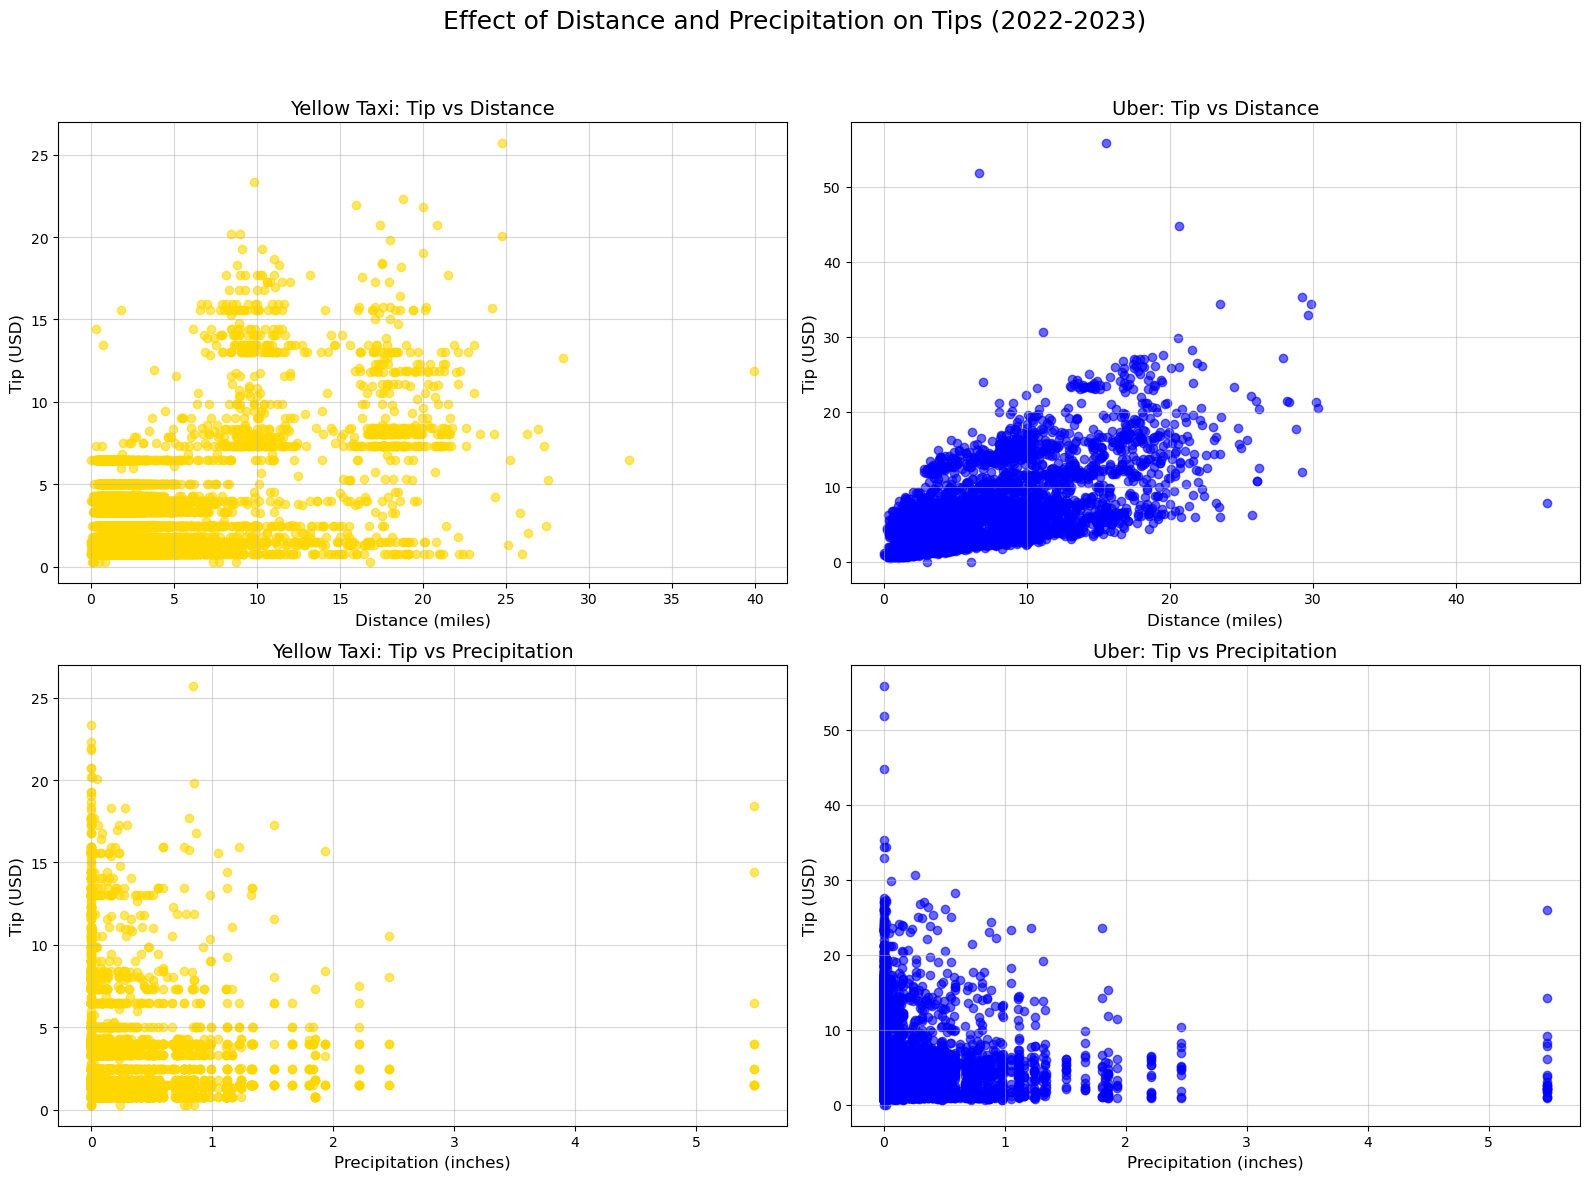

In [73]:
def get_data_for_visual_5() -> pd.DataFrame:
    """
    get the data for the  visual

    Returns:
    pd.DataFrame -- the data for the visual
    """

    sql = """
    WITH yellow_taxi_data AS (
        SELECT
            trip_pickup_datetime,
            trip_miles AS distance,
            (base_fare + tax + tolls + surcharge) - base_fare AS tip,
            COALESCE(DailyPrecipitation, 0) AS precipitation
        FROM taxi_trips
        LEFT JOIN daily_weather
            ON strftime('%Y-%m-%d', trip_pickup_datetime) = DATE_day
        WHERE strftime('%Y', trip_pickup_datetime) IN ('2022', '2023')
    ),
    uber_data AS (
        SELECT
            trip_pickup_datetime,
            trip_distance AS distance,
            (base_fare + tax + tolls + surcharge) - base_fare AS tip,
            COALESCE(DailyPrecipitation, 0) AS precipitation
        FROM uber_trips
        LEFT JOIN daily_weather
            ON strftime('%Y-%m-%d', trip_pickup_datetime) = DATE_day
        WHERE strftime('%Y', trip_pickup_datetime) IN ('2022', '2023')
    )
    SELECT 'Yellow Taxi' AS service, * FROM yellow_taxi_data
    UNION ALL
    SELECT 'Uber' AS service, * FROM uber_data;
    """
    results = pd.read_sql(sql, con=engine)
    return results

def plot_visual_5() -> None:
    """plot the fifth visual"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Effect of Distance and Precipitation on Tips (2022-2023)", fontsize=18)
    df = get_data_for_visual_5()
    # remove tip less than 0 
    df = df[df["tip"]>=0]
    yellow_df = df[df["service"] == "Yellow Taxi"]
    axes[0, 0].scatter(yellow_df["distance"], yellow_df["tip"], alpha=0.6, color="gold")
    axes[0, 0].set_title("Yellow Taxi: Tip vs Distance", fontsize=14)
    axes[0, 0].set_xlabel("Distance (miles)", fontsize=12)
    axes[0, 0].set_ylabel("Tip (USD)", fontsize=12)
    axes[0, 0].grid(alpha=0.5)


    uber_df = df[df["service"] == "Uber"]
    axes[0, 1].scatter(uber_df["distance"], uber_df["tip"], alpha=0.6, color="blue")
    axes[0, 1].set_title("Uber: Tip vs Distance", fontsize=14)
    axes[0, 1].set_xlabel("Distance (miles)", fontsize=12)
    axes[0, 1].set_ylabel("Tip (USD)", fontsize=12)
    axes[0, 1].grid(alpha=0.5)

    axes[1, 0].scatter(yellow_df["precipitation"].astype(float), yellow_df["tip"], alpha=0.6, color="gold")
    axes[1, 0].set_title("Yellow Taxi: Tip vs Precipitation", fontsize=14)
    axes[1, 0].set_xlabel("Precipitation (inches)", fontsize=12)
    axes[1, 0].set_ylabel("Tip (USD)", fontsize=12)
    axes[1, 0].grid(alpha=0.5)

    # Scatter Plot 4: Uber - Tip vs Precipitation
    axes[1, 1].scatter(uber_df["precipitation"].astype(float), uber_df["tip"], alpha=0.6, color="blue")
    axes[1, 1].set_title("Uber: Tip vs Precipitation", fontsize=14)
    axes[1, 1].set_xlabel("Precipitation (inches)", fontsize=12)
    axes[1, 1].set_ylabel("Tip (USD)", fontsize=12)
    axes[1, 1].grid(alpha=0.5)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_visual_5()


### Visualization 6 

In [74]:

def get_data_for_visual_6() -> pd.DataFrame:
    """
    get the data for the  visual

    Returns:
    pd.DataFrame -- the data for the visual
    """

    sql = """
    SELECT
        dropoff_latitude,
        dropoff_longitude
    FROM (
        SELECT dropoff_latitude, dropoff_longitude, trip_pickup_datetime FROM taxi_trips
        UNION ALL
        SELECT dropoff_latitude, dropoff_longitude, trip_pickup_datetime FROM uber_trips
    )
    WHERE strftime('%Y', trip_pickup_datetime) = '2020'
    AND dropoff_latitude IS NOT NULL
    AND dropoff_longitude IS NOT NULL;

    """

    results = pd.read_sql(sql,con=engine)
    return results

def plot_visual_6() -> folium.Map:
    """plot the sixth visual"""

    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
    df = get_data_for_visual_6()
    heat_data = list(zip(df["dropoff_latitude"], df["dropoff_longitude"]))
    HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(nyc_map)
    return nyc_map

plot_visual_6()